In [1]:
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
def getPriceChange(start, end):
    ClosePriceDifference = end - start
    ClosePricePercentDifference = (ClosePriceDifference/start) * 100
    print(f'YTD closing price percent change: {round(ClosePricePercentDifference,2)}%')
    
    return ClosePricePercentDifference


def getYTD(code):
    ticker_code = yf.Ticker(code)
    code_hist = ticker_code.history(period='ytd')
    code_hist = code_hist.reset_index()
    
    getPriceChange(code_hist.Close.iloc[0], code_hist.Close.iloc[-1])
    
    return code_hist

YTD closing price percent change: 10.89%
AxesSubplot(0.125,0.125;0.775x0.755)


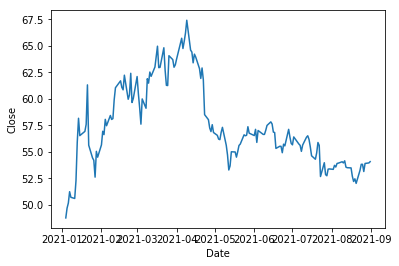

In [3]:
print(sns.lineplot(data=getYTD('INTC'), x='Date', y='Close'))

YTD closing price percent change: 19.96%


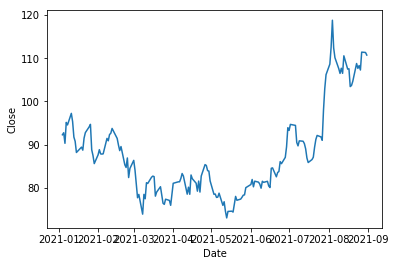

In [4]:
sns.lineplot(data=getYTD('AMD'), x='Date', y='Close')

YTD closing price percent change: 22.3%


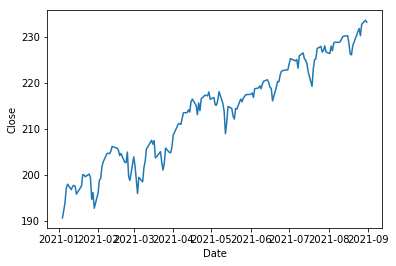

In [5]:
sns.lineplot(data=getYTD('VTI'), x='Date', y='Close')

In [6]:
# sns.lineplot(data=getYTD('NVDA'), x='Date', y='Close')
# sns.lineplot(data=getYTD('MSFT'), x='Date', y='Close')
# sns.lineplot(data=getYTD('CRM'), x='Date', y='Close')

In [7]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from numpy import cov

In [113]:
def correlationCal(data1, data2):
    
    #covariance
    covariance = cov(data1, data2)
#     print(covariance)
    
    #pearson correlation
    pearson_corr, _ = pearsonr(data1, data2)
    print('\nPearsons correlation: %.3f' % pearson_corr)
    
    # spearman correlation
    spearman_corr, _ = spearmanr(data1, data2)
    print('\nSpearmans correlation: %.3f' % spearman_corr)
    
    return pearson_corr, spearman_corr

In [116]:
correlationCal(getYTD('INTC')['Close'], getYTD('AMD')['Close'])

YTD closing price percent change: 10.89%
YTD closing price percent change: 19.96%

Pearsons correlation: -0.524

Spearmans correlation: -0.543


(-0.5242845461391962, -0.5434878811896877)

# Sharpe Calculation

In [12]:
intc = getYTD('INTC')
amd = getYTD('AMD')

YTD closing price percent change: 10.89%
YTD closing price percent change: 19.96%


In [15]:
for stock_df in (intc, amd):
    stock_df['Norm_return'] = stock_df['Close'] / stock_df.iloc[0]['Close']

In [19]:
for stock_df, allocation in zip((intc, amd),[.50,.50]):
    stock_df['Allocation'] = stock_df['Norm_return'] * allocation

In [21]:
Disposible_Income = 10000
for stock_df in (intc, amd):
    stock_df['Position'] = stock_df['Allocation']*Disposible_Income

In [34]:
all_pos = [intc['Position'], amd['Position']]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = ['intc_Pos','amd_Pos']

In [35]:
portf_val['Total_Pos'] = portf_val.sum(axis=1)
portf_val.head()

,intc_Pos,amd_Pos,Total_Pos
0,5000.000000,5000.000000,10000.000000
1,5094.624645,5025.460107,10120.084752
2,5143.949900,4893.282711,10037.232611
3,5253.674081,5154.929605,10408.603686
4,5199.315517,5123.510222,10322.825739


# Visualise Movement

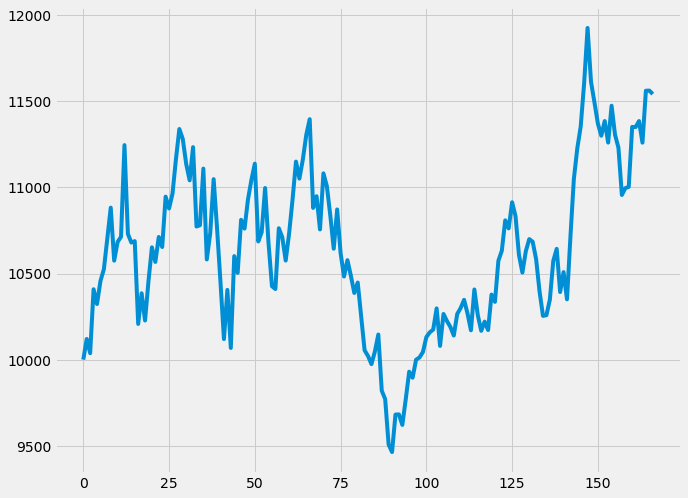

In [36]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
portf_val['Total_Pos'].plot(figsize=(10,8))

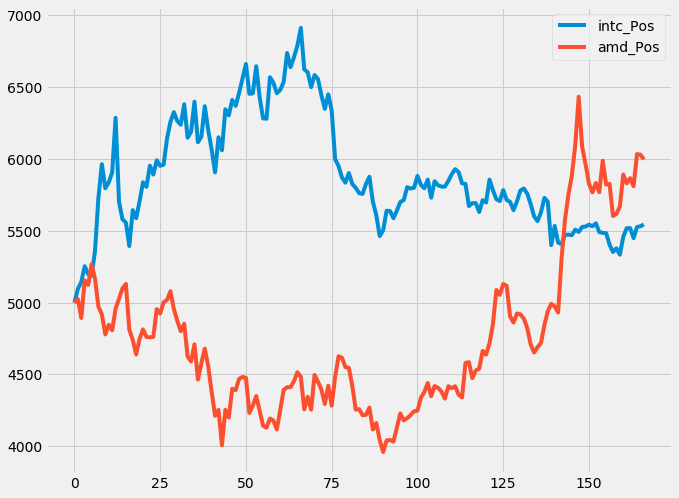

In [38]:
portf_val.drop('Total_Pos', axis=1).plot(figsize=(10,8))

In [106]:
def calROI(df, stock):
    initial_investment = df[stock].iloc[0]
    investment_return = df[stock].iloc[-1] 

    cumulative_return = 100*((investment_return-initial_investment)/initial_investment)
    print(f'{stock}\nInvestment gain of ${round(investment_return-initial_investment,2)}')
    print(f'Cumulative return was {round(cumulative_return,2)}%\n')
    
    return df.tail(1)

In [107]:
calROI(portf_val, 'Total_Pos')
calROI(portf_val, 'intc_Pos')
calROI(portf_val, 'amd_Pos')

Total_Pos
Investment gain of $1542.3
Cumulative return was 15.42%

intc_Pos
Investment gain of $544.47
Cumulative return was 10.89%

amd_Pos
Investment gain of $997.83
Cumulative return was 19.96%



,intc_Pos,amd_Pos,Total_Pos
166,5544.466713,5997.833021,11542.299734


In [108]:
portf_val['Daily_Return'] = portf_val['Total_Pos'].pct_change(1)

In [110]:
Sharpe_Ratio = portf_val['Daily_Return'].mean() / portf_val['Daily_Return'].std()

In [112]:
Sharpe_Ratio = (252**0.5)*Sharpe_Ratio
Sharpe_Ratio

0.8787301011234547

Ultimately, the correlation of -0.5 is less then adequate (greater then 0.7),  
and the sharpe ratio of 0.88 is also less then adequate (greater then 1.0, ideally greater then 2.0)

In [125]:
def assess(correlation, sharpeRatio):
    if (abs(correlation[0]) >= 0.7 or abs(correlation[1]) >= 0.7) and sharpeRatio >= 1.0:
        print(f'\ncorrelation is above recommended +/- 0.7, at {correlation[0]} and {correlation[1]}\n')
        print(f'Shapre ratio is above recommended 1.0, at {sharpeRatio}\n')
        print('assets are within sustainable portfolio management')
    elif (abs(correlation[0]) < 0.7 or abs(correlation[1]) < 0.7) or sharpeRatio < 1.0:
        print(f'\ncorrelation is below recommended +/- 0.7, at {correlation[0]} and {correlation[1]}\n')
        print(f'Shapre ratio is below recommended 1.0, at {sharpeRatio}\n')
        print('assets are not within sustainable portfolio management')

In [126]:
assess(correlationCal(getYTD('INTC')['Close'], getYTD('AMD')['Close']),Sharpe_Ratio)

YTD closing price percent change: 10.89%
YTD closing price percent change: 19.96%

Pearsons correlation: -0.524

Spearmans correlation: -0.543

correlation is below recommended +/- 0.7, at -0.5242845461391962 and -0.5434878811896877

Shapre ratio is below recommended 1.0, at 0.8787301011234547

assets are not within sustainable portfolio management
